In [ ]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [ ]:
# Standard imports
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

In [ ]:
!pip install tornado==6.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.9/426.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: tornado
    Found existing installation: tornado 6.3.3
    Uninstalling tornado-6.3.3:
      Successfully uninstalled tornado-6.3.3


In [ ]:
!pip install git+https://github.com/giswqs/geemap

  Cloning https://github.com/giswqs/geemap to /tmp/pip-req-build-csfd_4_c
  Running command git clone --filter=blob:none --quiet https://github.com/giswqs/geemap /tmp/pip-req-build-csfd_4_c
  Resolved https://github.com/giswqs/geemap to commit ff815098bf159f4b700b9ce4b1c4f36346470143
  Preparing metadata (setup.py) ... done


In [ ]:
from geemap import eefolium

ImportError: ignored

### Mount Drive

In [ ]:
# Mount drive to access content
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Authenticate google earth engine
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=UprPtTKunqa8U6q8OIhteDTBtZPnSoPTzcsuOCkEFxQ&tc=dJINi0xcAeAR5GzPK4n_AkLbyBku-DaLKpVNeqDYzXg&cc=MqbpjsR904gCVjtmssqoLtzl8wlm4SA1yAa2bIbTqRc

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BVudIUrTKIgXWhnPOtiy1zJXFDcNSNN9d6wGwsIcWEMZwN2a2FN8K4

Successfully saved authorization token.


In [ ]:
# Download country bounderies
ISO = 'DEU' # "DEU" is the ISO code for Germany
ADM = 'ADM2' # Equivalent to administrative districts

# Query geoBoundaries
r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM={}".format(ISO, ADM))
dl_path = r.json()[0]['gjDownloadURL']

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(dl_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (403, 6)


shapeName shapeISO              shapeID shapeGroup  \
357               Vogtlandkreis     None  DEU-ADM2-3_0_0-B358        DEU   
224             Kyffhyuserkreis     None  DEU-ADM2-3_0_0-B225        DEU   
216  Landkreis Fürstenfeldbruck     None  DEU-ADM2-3_0_0-B217        DEU   

    shapeType                                           geometry  
357      ADM2  MULTIPOLYGON (((12.58332 50.40755, 12.58358 50...  
224      ADM2  MULTIPOLYGON (((11.47574 51.29568, 11.47575 51...  
216      ADM2  MULTIPOLYGON (((11.41265 48.12743, 11.41279 48...

In [ ]:
# Plot label
shape_name = 'Kyffhyuserkreis'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

In [ ]:
# Form Google Engine download Sentinel-2 satellite imagery
# For simplicity RGB is selecctedd
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

In [ ]:
# Get the shape geometry for Kreis Borken
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2021-01-01', # Get all images within
    max_date='2021-12-31', # the year 2021
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

Map(center=[51.32477833885804, 10.984635394428874], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# import unicodedata
# export image to the drive as GeoTIFF
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """
    # normalized_name = unicodedata.normalize('NFKD', filename).encode('ASCII', 'ignore').decode('utf-8')
    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

In [ ]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(image, shape_name, region, folder)

Exporting to Kyffhyuserkreis.tif ...


In [ ]:
# check status of downloaded image
task.status()

{'state': 'COMPLETED',
 'description': 'Kyffhyuserkreis',
 'creation_timestamp_ms': 1692721236540,
 'update_timestamp_ms': 1692721564782,
 'start_timestamp_ms': 1692721245900,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1cPHhhfTsYDqET9b3euOjJDzPC1g17pqE'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 1018.9694213867188,
 'id': 'B4GDAJRZXLIEBL3LJFU6JKGC',
 'name': 'projects/earthengine-legacy/operations/B4GDAJRZXLIEBL3LJFU6JKGC'}

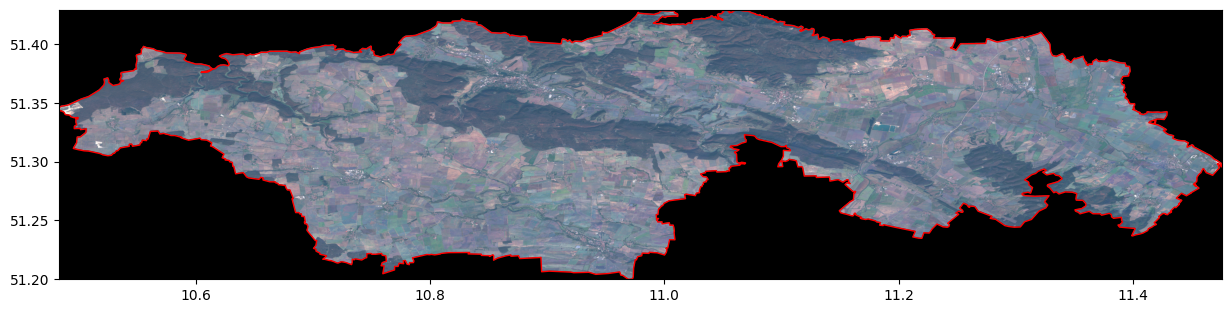

In [ ]:
# Visualize Sentinel-2A Image
# Change this to your image file path
cwd = './drive/My Drive/Colab Notebooks/'
shape_name = unicodedata.normalize('NFKD', shape_name).encode('ASCII', 'ignore').decode('utf-8')
tif_file = cwd + '{}.tif'.format(shape_name)

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

In [ ]:
# Generate 64x64 px GeoJSON Tiles
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

In [ ]:
# Create square polygons of size 64x64 px across the Kreis Borken Sentinel-2 satellite image.
output_file = cwd+'{}.geojson'.format(shape_name)
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)
print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/28286245 [00:00<?, ?it/s]

Data dimensions: (7093, 2)


id                                           geometry
0  kyffhyuserkreis-0  POLYGON ((10.48936 51.42388, 10.48936 51.42963...
1  kyffhyuserkreis-1  POLYGON ((10.49511 51.42388, 10.49511 51.42963...
2  kyffhyuserkreis-2  POLYGON ((10.50086 51.42388, 10.50086 51.42963...

In [ ]:
# Sentinel-2 raster file using Rasterio and superimpose the 64x64px vector polygons (Visualize 64x64 px Tiles)
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

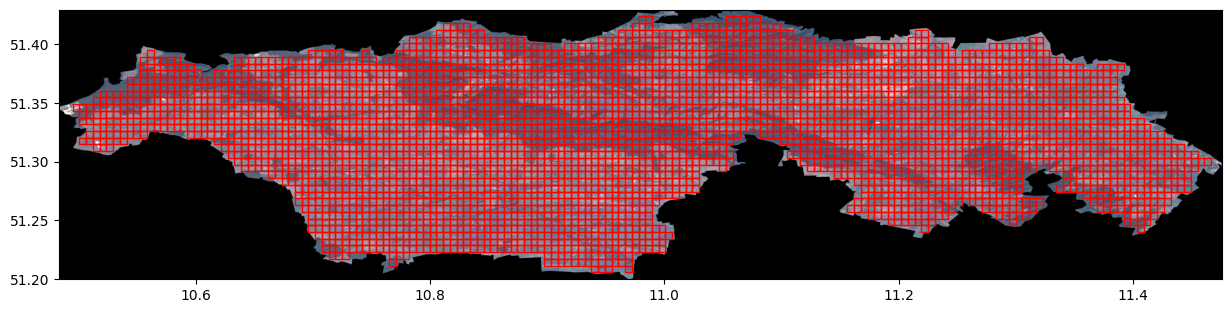

In [ ]:
# exclude the outward  region
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

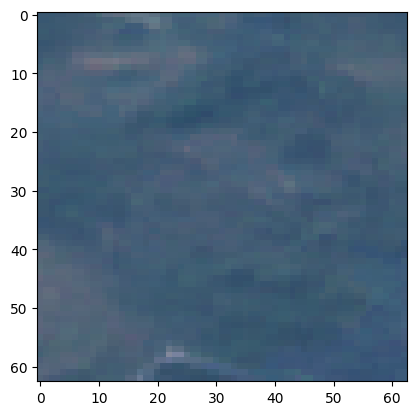

In [ ]:
# Visualize Single Cropped Image
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

In [ ]:
# Generate Land Use and Land Cover Map
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

In [ ]:
# Open our raster dataset
landsat_dataset = rasterio.open(tif_file)

# How many bands does this image have?
num_bands = landsat_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = landsat_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = landsat_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = landsat_dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 3

Image size is: 2561 rows x 11045 columns

Raster driver: GTiff

Image projection:
EPSG:4326


In [ ]:
# Load Model trained on EuroSAT
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'/models/best_model.pth'

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


Model file ./drive/My Drive/Colab Notebooks//models/best_model.pth successfully loaded.


In [ ]:
# Apply transformation to our new data
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [ ]:
# Model Prediction & LULC Map Generation
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = './drive/My Drive/Colab Notebooks/temp.tif'
        with rasterio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

In [ ]:
# Commence model prediction
labels = [] # Store predictions
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Cleanup temporary files
!rm './drive/My Drive/Colab Notebooks/temp.tif'

# Save predictions
filepath = cwd + "{}_preds.geojson".format(shape_name)
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/3742 [00:00<?, ?it/s]

id                                           geometry  \
259  kyffhyuserkreis-259  POLYGON ((10.98379 51.41813, 10.98379 51.42388...   
260  kyffhyuserkreis-260  POLYGON ((10.98954 51.41813, 10.98954 51.42388...   
272  kyffhyuserkreis-272  POLYGON ((11.05853 51.41813, 11.05853 51.42388...   

     index_right        shapeName shapeISO              shapeID shapeGroup  \
259          224  Kyffhyuserkreis     None  DEU-ADM2-3_0_0-B225        DEU   
260          224  Kyffhyuserkreis     None  DEU-ADM2-3_0_0-B225        DEU   
272          224  Kyffhyuserkreis     None  DEU-ADM2-3_0_0-B225        DEU   

    shapeType     pred  
259      ADM2  Pasture  
260      ADM2   Forest  
272      ADM2  Pasture

In [ ]:
# Visualize Interactive LULC Map
filepath = cwd + "{}_preds.geojson".format(shape_name)
tiles = gpd.read_file(filepath)
tiles.head(3)

id  index_right        shapeName shapeISO  \
0  kyffhyuserkreis-259          224  Kyffhyuserkreis     None   
1  kyffhyuserkreis-260          224  Kyffhyuserkreis     None   
2  kyffhyuserkreis-272          224  Kyffhyuserkreis     None   

               shapeID shapeGroup shapeType     pred  \
0  DEU-ADM2-3_0_0-B225        DEU      ADM2  Pasture   
1  DEU-ADM2-3_0_0-B225        DEU      ADM2   Forest   
2  DEU-ADM2-3_0_0-B225        DEU      ADM2  Pasture   

                                            geometry  
0  POLYGON ((10.98379 51.41813, 10.98379 51.42388...  
1  POLYGON ((10.98954 51.41813, 10.98954 51.42388...  
2  POLYGON ((11.05853 51.41813, 11.05853 51.42388...

In [ ]:
# Map each class to a corresponding color
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

id  index_right        shapeName shapeISO  \
0  kyffhyuserkreis-259          224  Kyffhyuserkreis     None   
1  kyffhyuserkreis-260          224  Kyffhyuserkreis     None   

               shapeID shapeGroup shapeType     pred  \
0  DEU-ADM2-3_0_0-B225        DEU      ADM2  Pasture   
1  DEU-ADM2-3_0_0-B225        DEU      ADM2   Forest   

                                            geometry    color  
0  POLYGON ((10.98379 51.41813, 10.98379 51.42388...  #3cb371  
1  POLYGON ((10.98954 51.41813, 10.98954 51.42388...  #228b22

In [ ]:

# Instantiate map centered on the centroid
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# Add Google Satellite basemap
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Add LULC Map with legend
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Specify the legend color
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Add GeoJSON to feature group
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map